In [87]:
import os
import datetime
import math

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import pmdarima as pm
import xgboost as xgb
import shap
from prophet import Prophet

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
import pandas as pd
pd.set_option('float_format', '{:4f}'.format)
# pd.options.display.float_format = "{:,.f}".format
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet, LassoLars, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
import joblib

from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
# from gluonts.torch import DeepAREstimator

from gluonts.torch.model.i_transformer import ITransformerEstimator

In [47]:
data_all = pd.read_excel('data/Data SP Ritel.xlsx', sheet_name='Monthly_Transaction')

In [49]:
data_ue_all = data_all[['Bulanan', 'nom_ue', 'vol_UE']].dropna().reset_index(drop=True)
data_ue_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Bulanan  197 non-null    datetime64[ns]
 1   nom_ue   197 non-null    float64       
 2   vol_UE   197 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 4.7 KB


In [50]:
data_ue_all

Bulanan          nom_ue            vol_UE
0   2008-01-01     1477.960000      95514.000000
1   2008-02-01     1446.200000      77452.000000
2   2008-03-01     1804.989739      95611.000000
3   2008-04-01     1984.984273     111626.000000
4   2008-05-01     2578.788521     159380.000000
..         ...             ...               ...
192 2024-01-01 81499600.132883 1139331766.000000
193 2024-02-01 81397175.298107 1128349557.000000
194 2024-03-01 90498047.097625 1247246122.000000
195 2024-04-01 90438269.261341 1266319105.000000
196 2024-05-01 94046551.740000 1335760144.000000

[197 rows x 3 columns]

<Axes: xlabel='Bulanan', ylabel='Volume UE'>

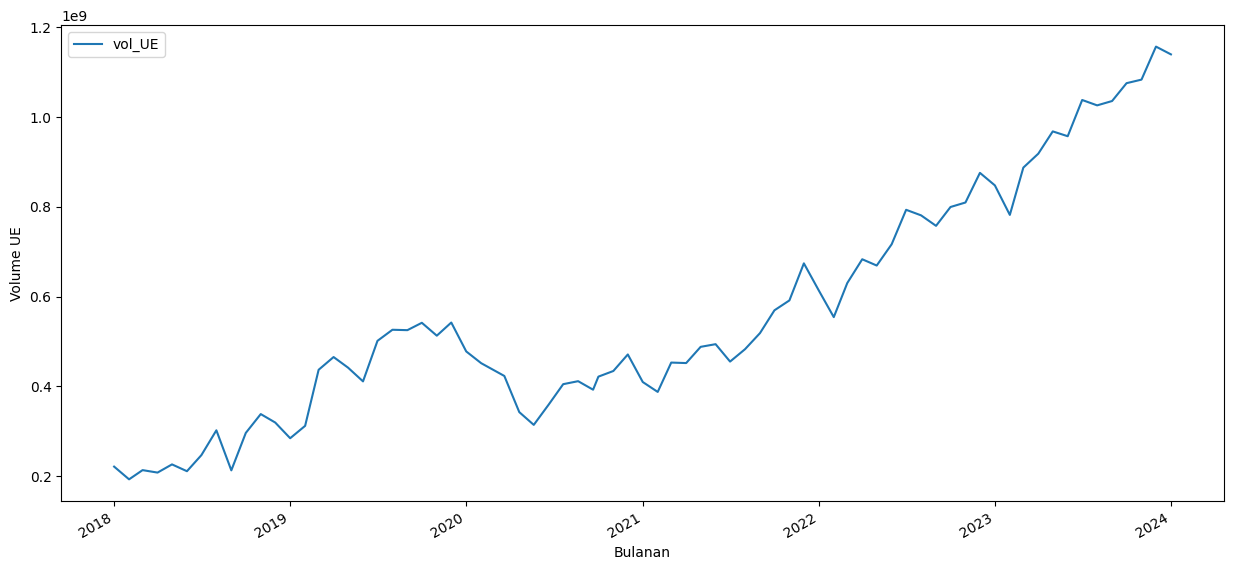

In [51]:
data_ue_all.iloc[120:-4].plot.line(x='Bulanan', y='vol_UE', figsize=(15,7), ylabel='Volume UE')

### ML part

In [112]:

def quartal_data(dff):
    dff = dff.iloc[:-2]
    dff['Bulanan'] = pd.to_datetime(dff['Bulanan'])
    df_resampled = dff.resample('Q', on='Bulanan').sum()
    return df_resampled.reset_index()

def feature_engineer(data, period):
    # Feature engineering
    data.set_index('Bulanan', inplace=True)

    # Ensure the data is at monthly frequency (if not already)
    data['month'] = data.index.month
    data['year'] = data.index.year

    # Perform STL Decomposition
    stl = STL(data['y_variable'], seasonal=13)
    result = stl.fit()

    # Extract components
    data['trend'] = result.trend
    data['seasonal'] = result.seasonal
    data['residual'] = result.resid

    # Ensure the data is at monthly frequency
    if period == 'M':
        data = data.resample('M').mean()

        # Calculate Moving Averages (3, 7, 12)
        ma_windows = [3]
        for window in ma_windows:
            data[f'moving_average_{window}'] = data['y_variable'].rolling(window=window).mean()
        # Calculate Month-over-Month (MoM) and Year-over-Year (YoY) changes
        data['mom'] = data['y_variable'].pct_change(periods=1) * 100  # MoM with period of 1 since it's monthly data
        data['yoy'] = data['y_variable'].pct_change(periods=12) * 100  # YoY with period of 12 months

        # Calculate MoM and YoY changes for each moving average
        for window in ma_windows:
            data[f'mom_ma_{window}'] = data[f'moving_average_{window}'].pct_change(periods=1) * 100
            data[f'yoy_ma_{window}'] = data[f'moving_average_{window}'].pct_change(periods=12) * 100
        # Define new dates to add
        new_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=3, freq='M')
        new_rows = pd.DataFrame(index=new_dates, columns=data.columns)
        data = pd.concat([data, new_rows])
        for feature in data.copy().drop(['month', 'year'], axis=1).columns:
            for lag in range(3, 13):
                data[f'{feature}_lag_{lag}'] = data[feature].shift(lag)
    elif period == 'Q':
         # Calculate Moving Averages (3, 7, 12)
        ma_windows = [4]
        for window in ma_windows:
            data[f'moving_average_{window}'] = data['y_variable'].rolling(window=window).mean()

        # Calculate Month-over-Month (MoM) and Year-over-Year (YoY) changes
        data['qtq'] = data['y_variable'].pct_change(periods=1) * 100  # MoM with period of 1 since it's monthly data
        for window in ma_windows:
            data[f'qtq_ma_{window}'] = data[f'moving_average_{window}'].pct_change(periods=1) * 100
        # Define new dates to add
        new_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(months=3), periods=8, freq='Q')
        new_rows = pd.DataFrame(index=new_dates, columns=data.columns)
        data = pd.concat([data, new_rows])
        for feature in data.copy().drop(['month', 'year'], axis=1).columns:
            for lag in range(8, 13):
                data[f'{feature}_lag_{lag}'] = data[feature].shift(lag)

    data_ = data.copy()
    data.dropna(inplace=True)
    return data, data_

In [113]:
def train_test_split_(data, ratio=0.8):
    # Train-test split
    train_size = int(len(data) * ratio)
    test_size = len(data) - train_size
    train, test = data.iloc[:train_size], data.iloc[train_size:]
    return train, test, train_size, test_size

def features_and_target(data, train, test):
    # Features and target
    features = data.copy().drop(['y_variable', 'month', 'year', 'trend', 'seasonal', 'residual'], axis=1).columns
    X_train, y_train = train[features], train['y_variable']
    X_test, y_test = test[features], test['y_variable']
    return X_train, y_train, X_test, y_test

def data_scaling(y_train, y_test):
    # Scale the target variable
    scaler = MinMaxScaler(feature_range=(-1, 1))
    y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))
    
    return y_train_scaled, y_test_scaled

# Function to calculate RMSE and MAPE
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return rmse, mape

def rename_y(data):
    data = data.rename(columns={'vol_UE': 'y_variable'})
    return data


In [114]:
# Load data
period_data = 'Q'
start_period =  '2013'
if period_data == 'Q':
    data = data_ue_all[['Bulanan', 'vol_UE']]
    # Create a directory for saving models
    model_save_path = f"saved_models_ue-vol_2013_{period_data}"
    os.makedirs(model_save_path, exist_ok=True)
elif period_data == 'M':
    if start_period == '2013':
        data = data_ue_all[['Bulanan', 'vol_UE']].iloc[36:] #from 2013
        model_save_path = f"saved_models_ue-vol_{start_period}_{period_data}"
        os.makedirs(model_save_path, exist_ok=True)
    elif start_period == '2018':
        data = data_ue_all[['Bulanan', 'vol_UE']].iloc[96:] #from 2018
        model_save_path = f"saved_models_ue-vol_{start_period}_{period_data}"
        os.makedirs(model_save_path, exist_ok=True)

data = rename_y(data)
data = quartal_data(data)

data, data_ = feature_engineer(data, period=period_data)
train, test, train_size, test_size = train_test_split_(data)
X_train, y_train, X_test, y_test = features_and_target(data, train, test)

C:\Users\arnanda_p.i\AppData\Local\Temp\ipykernel_22784\1020852284.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['Bulanan'] = pd.to_datetime(dff['Bulanan'])
C:\Users\arnanda_p.i\AppData\Local\Temp\ipykernel_22784\1020852284.py:4: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df_resampled = dff.resample('Q', on='Bulanan').sum()
C:\Users\arnanda_p.i\AppData\Local\Temp\ipykernel_22784\1020852284.py:58: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  new_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(months=3), periods=8, freq='Q')
C:\Users\arnanda_p.i\AppData\Local\Temp\ipykernel_22784\1020852284.py:60: FutureWarning: The

#### ML Modeling

In [96]:
# Initialize models and hyperparameter grids
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    # 'Ridge Regression':{
    #     'model': Ridge(),
    #     'params': {
    #         'model__alpha': [1, 10, 100],
    #         'model__max_iter': [1000, 15000]
    #     }
    # },
    'SGD Regression': {
        'model': SGDRegressor(),
        'params': {
            'model__loss': ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
            'model__penalty': ['l2', 'l1', 'elasticnet'],
            'model__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
        }
    },
    'Elastic Net': {
        'model': ElasticNet(),
        'params': {
            'model__l1_ratio': [0.1, 0.25, 0.5, 1],
            'model__max_iter': [1000, 2000, 10000]
        }
    },
    # 'Lasso Lars': {
    #     'model': LassoLars(),
    #     'params': {
    #         'model__max_iter': [500, 1000, 2000]
    #     }
    # },
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'model__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
            'model__splitter': ['best', 'random'],
            'model__max_depth': [1, 3, 5, 7, 9]
        }
    },
    'KNN':{
        'model': KNeighborsRegressor(),
        'params': {
            'model__n_neighbors': [1, 2, 5, 10],
            'model__weights': ['uniform', 'distance'],
            'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'model__leaf_size': [30, 50, 100]
        }
    },
    # 'Lasso Regression': {
    #     'model': Lasso(),
    #     'params': {
    #         'model__max_iter': [500, 1000, 2000]
    #     }
    # },
    'Multi Layer Perceptron Regressor NN': {
        'model': MLPRegressor(),
        'params': {
            'model__activation': ['identity', 'logistic', 'tanh', 'relu'],
            'model__max_iter': [10000],
            'model__hidden_layer_sizes': [10, 50, 100, 200, 1000],
            'model__solver': ['adam'],
            'model__learning_rate': ['constant', 'invscaling', 'adaptive'],
            'model__early_stopping': [True],
            'model__learning_rate_init': [0.0001, 0.001, 0.01]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': {
            'model__n_estimators': [50, 75, 100, 200, 1000]
        }
    },
    # 'Support Vector Regression': {
    #     'model': SVR(),
    #     'params': {
    #         'model__kernel': ['linear'],
    #         'model__C': [0.1, 1, 10],
    #         'model__gamma': ['scale', 'auto']
    #     }
    # },
    'XGBoost': {
        'model': XGBRegressor(),
        'params': {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5, 7]
        }
    },
    'LightGBM': {
        'model': LGBMRegressor(),
        'params': {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__num_leaves': [31, 40, 50]
        }
    }
}

Linear Regression
SGD Regression


C:\Users\arnanda_p.i\AppData\Local\Temp\ipykernel_22784\3037799946.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame([{


Elastic Net


C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.321e+15, tolerance: 9.547e+14
  model = cd_fast.enet_coordinate_descent(
C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.750e+15, tolerance: 1.010e+15
  model = cd_fast.enet_coordinate_descent(
C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

Decision Tree
KNN
Multi Layer Perceptron Regressor NN
Random Forest
XGBoost
LightGBM
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 0
[LightGBM] [Info] Start training from score 643072218.322581
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requireme

C:\Users\arnanda_p.i\AppData\Local\Temp\ipykernel_22784\3037799946.py:134: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df_top = pd.concat([metrics_df_top, pd.DataFrame([{


Elastic Net


C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.750e+18, tolerance: 9.547e+14
  model = cd_fast.enet_coordinate_descent(
C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.826e+18, tolerance: 1.010e+15
  model = cd_fast.enet_coordinate_descent(
C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

Decision Tree
KNN
Multi Layer Perceptron Regressor NN
Random Forest
XGBoost
LightGBM
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 0
[LightGBM] [Info] Start training from score 643072218.322581
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requireme

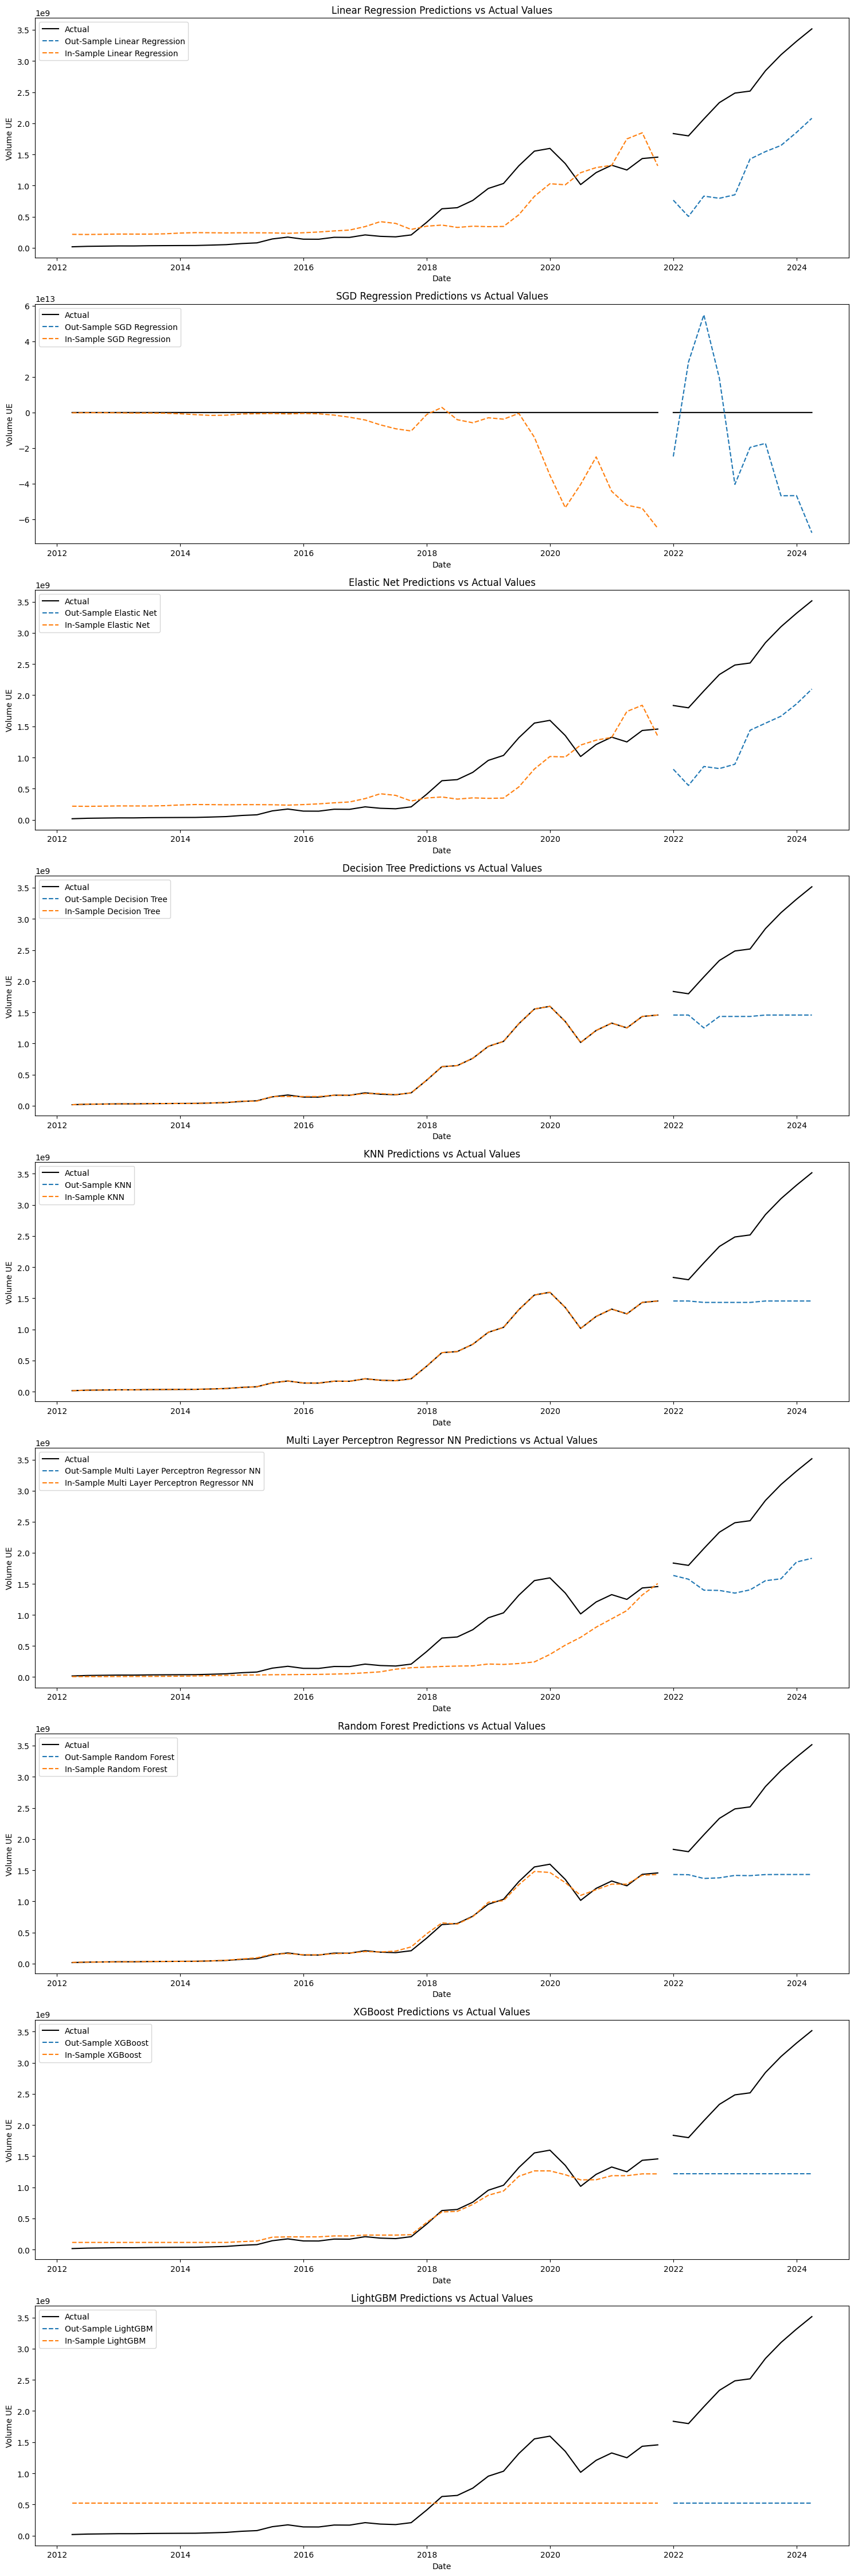

Model  \
0  Multi Layer Perceptron Regressor NN   
1                          Elastic Net   
2                    Linear Regression   
3                        Random Forest   
4                                  KNN   
5                        Decision Tree   
6                              XGBoost   
7                             LightGBM   
8                       SGD Regression   

                                         Best Params            Train RMSE  \
0  {'model__activation': 'relu', 'model__early_st...      448656730.782859   
1  {'model__l1_ratio': 0.25, 'model__max_iter': 1...      317017807.248625   
2                                                 {}      316952814.420575   
3                        {'model__n_estimators': 50}       36240544.329734   
4  {'model__algorithm': 'brute', 'model__leaf_siz...              0.000000   
5  {'model__criterion': 'squared_error', 'model__...        5367202.839763   
6  {'model__learning_rate': 0.01, 'model__max_dep...      114143086.657337   
7  {'model__learning_rate': 0.01, 'model__n_estim...      553294373.281163   
8  {'model__alpha': 0.01, 'model__loss': 'huber',... 21917351754707.382812   

              Test RMSE   Train MAPE    Test MAPE  selisih MAPE  \
0     1123566412.961604     0.592887     0.369856      0.223031   
1     1338097719.932782     2.211357     0.531409      1.679948   
2     1362243377.468780     2.200134     0.542503      1.657630   
3     1293224586.091288     0.052954     0.423781      0.370827   
4     1267201246.093656     0.000000     0.410537      0.410537   
5     1277686315.637529     0.018088     0.419414      0.401326   
6     1478882642.371574     0.921027     0.504517      0.416510   
7     2140646349.718515     5.428210     0.789246      4.638964   
8 40088394232748.796875 18219.163170 14267.305024   3951.858146   

           selisih RMSE  
0      674909682.178746  
1     1021079912.684157  
2     1045290563.048205  
3     1256984041.761554  
4     1267201246.093656  
5     1272319112.797766  
6     1364739555.714237  
7     1587351976.437352  
8 18171042478041.414062

In [97]:


# Train models, perform hyperparameter tuning, and evaluate metrics
results = {}
predictions = {}
train_predictions = {}
metrics_df = pd.DataFrame(columns=['Model', 'Best Params', 'Train RMSE', 'Test RMSE', 'Train MAPE', 'Test MAPE'])

for name, model_info in models.items():
    pipeline = Pipeline([
        ('model', model_info['model'])
    ])
    print(name)
    grid_search = GridSearchCV(pipeline, model_info['params'], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    
    # Save the best model
    model_filename = os.path.join(model_save_path, f"{name.replace(' ', '_')}_best_model.pkl")
    joblib.dump(best_model, model_filename)

    # Predictions
    train_pred = best_model.predict(X_train)
    test_pred = best_model.predict(X_test)
    predictions[name] = test_pred
    train_predictions[name] = train_pred
    
    # Calculate metrics
    train_rmse, train_mape = calculate_metrics(y_train, train_pred)
    test_rmse, test_mape = calculate_metrics(y_test, test_pred)
    
    results[name] = {
        'Best Params': grid_search.best_params_,
        'Train RMSE': train_rmse, 'Test RMSE': test_rmse,
        'Train MAPE': train_mape, 'Test MAPE': test_mape
    }

   # Append metrics to DataFrame
    metrics_df = pd.concat([metrics_df, pd.DataFrame([{
        'Model': name,
        'Best Params': grid_search.best_params_,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAPE': train_mape,
        'Test MAPE': test_mape,
    }])], ignore_index=True)

# Calculate SHAP values and feature importance
feature_importances = {}

for name in models.keys():
    model_filename = os.path.join(model_save_path, f"{name.replace(' ', '_')}_best_model.pkl")
    best_model = joblib.load(model_filename)
    
    # SHAP values
    try:
        if name == "Random Forest" or name == "XGBoost" or name == "Decison Tree":
            explainer = shap.TreeExplainer(best_model.named_steps['model'], X_train)
        elif name == "Linear Regression":
            explainer = shap.LinearExplainer(best_model.named_steps['model'], X_train)
        elif name == "Multi Layer Perceptron Regressor NN":
            explainer = shap.DeepExplainer(best_model.named_steps['model'], X_train)
        elif name == "KNN":
            explainer = shap.KernelExplainer(best_model.named_steps['model'], X_train)
        else:
            # For other types of models
            explainer = shap.Explainer(best_model.named_steps['model'], X_train)
    except Exception as e:
        print("Error:", e)
        continue    
    # explainer = shap.Explainer(best_model.named_steps['model'], X_train, algorithm="auto")
    shap_values = explainer(X_train)
    
    # Calculate mean absolute SHAP values for each feature
    feature_importance = np.abs(shap_values.values).mean(axis=0)
    feature_importances[name] = feature_importance

    # Plot feature importance
    shap.summary_plot(shap_values, X_train, show=False)
    plt.title(f"Feature Importance for {name}")
    plt.savefig(os.path.join(model_save_path, f"{name.replace(' ', '_')}_feature_importance.png"))
    plt.close()

# Determine the most important features across all models
all_importances = np.array([importance for importance in feature_importances.values()])
mean_importance = np.mean(all_importances, axis=0)
sorted_indices = np.argsort(mean_importance)[::-1]
if period_data == 'M':
    top_features = X_train.columns[sorted_indices][:5]  # Top 5 most important features
elif period_data == 'Q':
    top_features = X_train.columns[sorted_indices][:4]  # Top 4 most important features

print("Top 5 most important features across all models:")
print(top_features)

# Re-train models using only the top features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Re-train models and evaluate with top features
results_top = {}
metrics_df_top = pd.DataFrame(columns=['Model', 'Best Params', 'Train RMSE', 'Test RMSE', 'Train MAPE', 'Test MAPE'])

for name, model_info in models.items():
    pipeline = Pipeline([
        ('model', model_info['model'])
    ])
    print(name)
    grid_search = GridSearchCV(pipeline, model_info['params'], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_top, y_train)
    
    best_model = grid_search.best_estimator_
    
    # Save the best model with top features
    model_filename = os.path.join(model_save_path, f"{name.replace(' ', '_')}_best_model_top_features.pkl")
    joblib.dump(best_model, model_filename)

    # Predictions with top features
    train_pred = best_model.predict(X_train_top)
    test_pred = best_model.predict(X_test_top)
    predictions[name] = test_pred
    train_predictions[name] = train_pred
    
    # Calculate metrics with top features
    train_rmse, train_mape = calculate_metrics(y_train, train_pred)
    test_rmse, test_mape = calculate_metrics(y_test, test_pred)
    
    results_top[name] = {
        'Best Params': grid_search.best_params_,
        'Train RMSE': train_rmse, 'Test RMSE': test_rmse,
        'Train MAPE': train_mape, 'Test MAPE': test_mape
    }

    # Append metrics to DataFrame
    metrics_df_top = pd.concat([metrics_df_top, pd.DataFrame([{
        'Model': name,
        'Best Params': grid_search.best_params_,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAPE': train_mape,
        'Test MAPE': test_mape,
    }])], ignore_index=True)

# Print evaluation results
for name, metrics in results.items():
    print(f"{name} - Best Params: {metrics['Best Params']}")
    print(f"{name} - Train RMSE: {metrics['Train RMSE']:.4f}, Test RMSE: {metrics['Test RMSE']:.4f}")
    print(f"{name} - Train MAPE: {metrics['Train MAPE']:.4f}, Test MAPE: {metrics['Test MAPE']:.4f}")

# Plot predictions
fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(15, len(models) * 5))
axes = axes.flatten()
plt.subplots_adjust(hspace=0.5)

for ax, (name, pred), (t_name, t_pred) in zip(axes, predictions.items(), train_predictions.items()):
    ax.plot(test.index, y_test, label='Actual', color='black')
    ax.plot(test.index, pred, label=f'Out-Sample {name}', linestyle='--')
    ax.plot(train.index, y_train, color='black')
    ax.plot(train.index, t_pred, label=f'In-Sample {t_name}', linestyle='--')
    ax.legend()
    ax.set_title(f'{name} Predictions vs Actual Values')
    ax.set_xlabel('Date')
    ax.set_ylabel('Volume UE')

plt.tight_layout()
plt.show()

metrics_df['selisih MAPE'] = abs(metrics_df['Train MAPE'] - metrics_df['Test MAPE'])
metrics_df['selisih RMSE'] = abs(metrics_df['Train RMSE'] - metrics_df['Test RMSE'])

metrics_df_top['selisih MAPE'] = abs(metrics_df_top['Train MAPE'] - metrics_df_top['Test MAPE'])
metrics_df_top['selisih RMSE'] = abs(metrics_df_top['Train RMSE'] - metrics_df_top['Test RMSE'])

display(metrics_df_top.sort_values(by=['selisih RMSE', 'selisih MAPE'], ascending=True).reset_index(drop=True))

In [98]:
importance_sum = np.sum(mean_importance)
proportions = mean_importance[sorted_indices][:5] / importance_sum

print(f"Top {len(top_features)} most important features across all models:")
for feature, proportion in zip(top_features, proportions):
    print(f"{feature}: {proportion:.2%}")

Top 4 most important features across all models:
y_variable_lag_10: 15.10%
trend_lag_8: 13.14%
trend_lag_9: 10.72%
y_variable_lag_8: 10.15%


In [99]:
# display(metrics_df.sort_values(by=['selisih RMSE', 'selisih MAPE'], ascending=True).reset_index(drop=True))
display(f"Top {len(top_features)} most important features across all models:{top_features}")
display(metrics_df_top.sort_values(by=['selisih RMSE', 'selisih MAPE'], ascending=True).reset_index(drop=True))

"Top 4 most important features across all models:Index(['y_variable_lag_10', 'trend_lag_8', 'trend_lag_9', 'y_variable_lag_8'], dtype='object')"

Model  \
0  Multi Layer Perceptron Regressor NN   
1                          Elastic Net   
2                    Linear Regression   
3                        Random Forest   
4                                  KNN   
5                        Decision Tree   
6                              XGBoost   
7                             LightGBM   
8                       SGD Regression   

                                         Best Params            Train RMSE  \
0  {'model__activation': 'relu', 'model__early_st...      448656730.782859   
1  {'model__l1_ratio': 0.25, 'model__max_iter': 1...      317017807.248625   
2                                                 {}      316952814.420575   
3                        {'model__n_estimators': 50}       36240544.329734   
4  {'model__algorithm': 'brute', 'model__leaf_siz...              0.000000   
5  {'model__criterion': 'squared_error', 'model__...        5367202.839763   
6  {'model__learning_rate': 0.01, 'model__max_dep...      114143086.657337   
7  {'model__learning_rate': 0.01, 'model__n_estim...      553294373.281163   
8  {'model__alpha': 0.01, 'model__loss': 'huber',... 21917351754707.382812   

              Test RMSE   Train MAPE    Test MAPE  selisih MAPE  \
0     1123566412.961604     0.592887     0.369856      0.223031   
1     1338097719.932782     2.211357     0.531409      1.679948   
2     1362243377.468780     2.200134     0.542503      1.657630   
3     1293224586.091288     0.052954     0.423781      0.370827   
4     1267201246.093656     0.000000     0.410537      0.410537   
5     1277686315.637529     0.018088     0.419414      0.401326   
6     1478882642.371574     0.921027     0.504517      0.416510   
7     2140646349.718515     5.428210     0.789246      4.638964   
8 40088394232748.796875 18219.163170 14267.305024   3951.858146   

           selisih RMSE  
0      674909682.178746  
1     1021079912.684157  
2     1045290563.048205  
3     1256984041.761554  
4     1267201246.093656  
5     1272319112.797766  
6     1364739555.714237  
7     1587351976.437352  
8 18171042478041.414062

In [100]:
test_df = pd.DataFrame()
for name, pred in predictions.items():
    test_df[name] = pred

test_df = test_df.set_index(y_test.index)
test_df['actual'] = y_test
test_df.iloc[-1]

Linear Regression                          2080290070.073541
SGD Regression                        -67618214671856.226562
Elastic Net                                2098264173.335771
Decision Tree                              1456315598.028229
KNN                                        1456315598.028229
Multi Layer Perceptron Regressor NN        1911583063.754646
Random Forest                              1431321990.668761
XGBoost                                    1216118272.000000
LightGBM                                    517276280.974359
actual                                     3514927445.000000
Name: 2024-03-31 00:00:00, dtype: float64

In [116]:
data_[-8:][top_features]

y_variable_lag_10       trend_lag_8       trend_lag_9  \
2024-06-30  1834555555.203393 2088756649.840981 1899016223.584234   
2024-09-30  1797605420.000000 2263718313.119699 2088756649.840981   
2024-12-31  2068433883.678013 2444385480.616555 2263718313.119699   
2025-03-31  2331379693.000000 2635417082.264911 2444385480.616555   
2025-06-30  2484242405.000000 2840611239.738039 2635417082.264911   
2025-09-30  2516481929.412086 3071268795.215257 2840611239.738039   
2025-12-31  2842951037.001585 3308349492.164737 3071268795.215257   
2026-03-31  3098918748.000000 3544747854.877966 3308349492.164737   

            y_variable_lag_8  
2024-06-30 2068433883.678013  
2024-09-30 2331379693.000000  
2024-12-31 2484242405.000000  
2025-03-31 2516481929.412086  
2025-06-30 2842951037.001585  
2025-09-30 3098918748.000000  
2025-12-31 3314919414.000000  
2026-03-31 3514927445.000000

In [38]:
# Path to the directory where models are saved
model_save_path = "saved_models_ue-vol_2018"

# Load models into a dictionary
loaded_models = {}
for model_name in os.listdir(model_save_path):
    model_path = os.path.join(model_save_path, model_name)
    model_key = model_name.replace('_best_model_top_features.pkl', '').replace('_', ' ')
    loaded_models[model_key] = joblib.load(model_path)

# Sample new data (replace with your actual new data)
X_forecast = full_data[features][-3:]
# Dictionary to store predictions
next_predictions = {}

# Predict next 3 values using each loaded model
for model_name, model in loaded_models.items():
    predictions = model.predict(X_forecast)
    next_predictions[model_name] = predictions
    print(f"Predictions for {model_name}: {predictions}")

# Convert predictions to DataFrame for better readability
predictions_df = pd.DataFrame(next_predictions, index=X_forecast.index)
# predictions_df['Actual Value'] = '94046551734753.0'
display(predictions_df)

result_fc = predictions_df.loc[:'2024-05-31'].T
result_fc['Actual Value'] = '1,335,760,144'
display(result_fc)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- mom
- mom_lag_10
- mom_lag_11
- mom_lag_12
- mom_lag_3
- ...


### TS Part

In [61]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from prophet import Prophet
from pytorch_forecasting import DeepAR, TimeSeriesDataSet
# from gluonts.mx import DeepAREstimator
from pmdarima import auto_arima
from pmdarima import model_selection 
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing


#### Prophet

In [71]:
import itertools
import numpy as np
import pandas as pd
from prophet.diagnostics import cross_validation, performance_metrics

fb_train = train.reset_index().rename(columns={"y_variable":"y",'Bulanan':'ds'})
# fb_train_ = data.reset_index().rename(columns={"vol_UE":"y",'Bulanan':'ds'})

In [72]:

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(fb_train)  # Fit model with given params
    df_cv = cross_validation(m, horizon='3 MS',  parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:Adding TBB (C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\prophet\stan_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\ARNAND~1.I\AppData\Local\Temp\tmp10r0ol9y\mxqd9xfe.json
DEBUG:cmdstanpy:input tempfile: C:\Users\ARNAND~1.I\AppData\Local\Temp\tmp10r0ol9y\xc9n2gx5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\arnanda_p.i\\AppData\\Roaming\\Python\\Python39\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=82719', 'data', 'file=C:\\Users\\ARNAND~1.I\\AppData\\Local\\Temp\\tmp10r0ol9y\\mxqd9xfe.json', 'init=C:\\Users\\ARNAND~1.I\\AppData\\Local\\Temp\\tmp10r

    changepoint_prior_scale  seasonality_prior_scale             rmse
0                  0.001000                 0.010000 275048497.105943
1                  0.001000                 0.100000 290631516.937749
2                  0.001000                 1.000000 304964696.038310
3                  0.001000                10.000000 315878188.331950
4                  0.010000                 0.010000 282084659.042857
5                  0.010000                 0.100000 292643570.663986
6                  0.010000                 1.000000 308738727.616923
7                  0.010000                10.000000 317531531.388995
8                  0.100000                 0.010000 259084685.115211
9                  0.100000                 0.100000 265753534.184286
10                 0.100000                 1.000000 260467457.294017
11                 0.100000                10.000000 229703612.833951
12                 0.500000                 0.010000 195720419.680009
13                 0

In [79]:
fb_model = Prophet(**all_params[np.argmin(rmses)])
fb_model.fit(fb_train)

if period_data == 'M':
    future_dates = fb_model.make_future_dataframe(periods=test_size, freq='MS')
elif period_data == 'Q':
    future_dates = fb_model.make_future_dataframe(periods=test_size, freq='QS')

# future_dates_ = fb_model.make_future_dataframe(periods=3, freq='MS')
forecast = fb_model.predict(future_dates)
# forecast_ = fb_model.predict(future_dates_)

print(all_params[np.argmin(rmses)])

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\ARNAND~1.I\AppData\Local\Temp\tmp10r0ol9y\ej3mj9p6.json
DEBUG:cmdstanpy:input tempfile: C:\Users\ARNAND~1.I\AppData\Local\Temp\tmp10r0ol9y\65507voc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\arnanda_p.i\\AppData\\Roaming\\Python\\Python39\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=28625', 'data', 'file=C:\\Users\\ARNAND~1.I\\AppData\\Local\\Temp\\tmp10r0ol9y\\ej3mj9p6.json', 'init=C:\\Users\\ARNAND~1.I\\AppData\\Local\\Temp\\tmp10r0ol9y\\65507voc.json', 'output', 'file=C:\\Users\\ARNAND~1.I\\AppData\\Local\\Temp\\tmp10r0ol9y\\prophet_modelow8w5tj0

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0}


In [80]:
forecast

ds             trend        yhat_lower        yhat_upper  \
0  2012-03-31 2256800351.157155  -30536762.570085  150367104.469756   
1  2012-06-30 2248146631.431629 -114904092.554085   54469445.183037   
2  2012-09-30 2239397815.641388  -88042575.238030   87223010.814102   
3  2012-12-31 2230648999.729527  -52447237.272595  121828359.578819   
4  2013-03-31 2222090375.467924  -47177853.135788  135059585.137769   
5  2013-06-30 2213436655.588351  -70373982.783013  104046315.332118   
6  2013-09-30 2204687839.759981  -57848318.942124  115258571.023718   
7  2013-12-31 2195939023.846962  -34983529.762089  148847317.008747   
8  2014-03-31 2187380580.979652  -54938125.069630  117629764.153532   
9  2014-06-30 2178728798.955909  -29440626.578032  152092892.964107   
10 2014-09-30 2169981942.404432  -13837849.556244  162879887.223226   
11 2014-12-31 2161261085.331280   -6445008.838718  164588629.176640   
12 2015-03-31 2184814880.117786  -24741694.438754  142992454.672010   
13 2015-06-30 2208634488.637990   78664580.241166  250345982.812052   
14 2015-09-30 2232732357.046527  136305450.259654  312987904.061856   
15 2015-12-31 2259663411.265251  166030334.692320  334921507.419226   
16 2016-03-31 2286301736.633771    3508992.470138  181501509.548409   
17 2016-06-30 2312940061.930900  -49509902.049105  127400848.477427   
18 2016-09-30 2339870520.166394   13826836.334329  193499323.740440   
19 2016-12-31 2366795252.461594   74957797.418224  255943832.269458   
20 2017-03-31 2393134664.655503  128725801.007610  299233127.651851   
21 2017-06-30 2419766736.993793  133893491.935552  308862909.841730   
22 2017-09-30 2446691469.467670  184972521.039767  358216694.015940   
23 2017-12-31 2571824517.645576  343696327.159560  514724051.418897   
24 2018-03-31 2694267006.434212  449754968.941381  627082505.268501   
25 2018-06-30 2818070899.748083  605744739.055783  786861936.673336   
26 2018-09-30 2943581375.576158  752189992.267743  931930600.685675   
27 2018-12-31 3069105437.031812  902571422.209082 1076867093.765470   
28 2019-03-31 3191900714.542777  976693828.037001 1152450567.670959   
29 2019-06-30 3316060384.247818 1186389306.979933 1361445189.170230   
30 2019-09-30 3441584445.166097 1346142270.051083 1524274612.699050   
31 2019-12-31 3458236746.088838 1361910951.879571 1533240468.955491   
32 2020-03-31 3474708043.740679 1196293564.810217 1371736783.294335   
33 2020-06-30 3491179341.392520 1122164691.464337 1299401677.145810   
34 2020-09-30 3507831642.315261 1185293066.692214 1361450571.175913   
35 2020-12-31 3524483943.238002 1237883853.419344 1415210348.131560   
36 2021-03-31 3540774237.618945 1272615390.730130 1451717830.656479   
37 2021-06-30 3557245535.270785 1273904398.050337 1446318868.837516   
38 2021-09-30 3573897836.193526 1309332954.087368 1486887071.052051   
39 2021-10-01 3574078839.464426 1149174028.519693 1324215520.087741   
40 2022-01-01 3590731140.387167 1177607215.038187 1357146689.827256   
41 2022-04-01 3607021434.768108 1316785324.377848 1509051576.653418   
42 2022-07-01 3623492732.419950 1064467932.615551 1292293878.222208   
43 2022-10-01 3640145033.342691 1202113615.599321 1447505618.608529   
44 2023-01-01 3656797334.265431 1222270362.919050 1509110757.236827   
45 2023-04-01 3673087628.646373 1313935600.033205 1646723378.985000   
46 2023-07-01 3689558926.298215 1132923303.836187 1541705863.375995   
47 2023-10-01 3706211227.220956 1197447503.933646 1646778048.821359   
48 2024-01-01 3722863528.143697 1210408633.726638 1750626094.045834   

         trend_lower       trend_upper     additive_terms  \
0  2256800351.157155 2256800351.157155 -2192809496.419012   
1  2248146631.431629 2248146631.431629 -2277403402.845772   
2  2239397815.641388 2239397815.641388 -2238122319.863031   
3  2230648999.729527 2230648999.729527 -2198247446.927208   
4  2222090375.467924 2222090375.467924 -2179446429.173676   
5  2213436655.588351 2213436655.588351 -2197758010.091842   
6  2204687839.759981 2204687839.7

C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


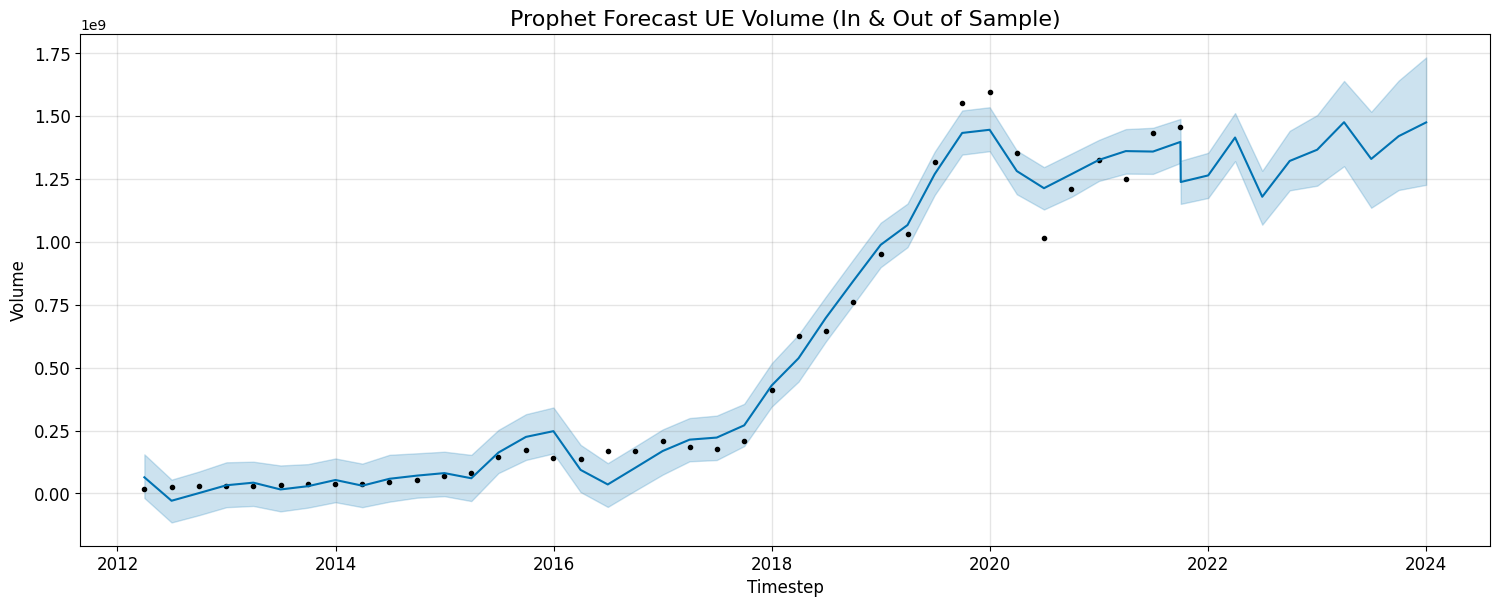

In [75]:
fig = fb_model.plot(forecast, uncertainty=True, figsize=(15,6))
ax = fig.gca()
ax.set_title("Prophet Forecast UE Volume (In & Out of Sample)", size=16)
ax.set_xlabel("Timestep", size=12)
ax.set_ylabel("Volume", size=12)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

In [81]:
train_rmse, train_mape = calculate_metrics(data['y_variable'].iloc[:train_size], forecast['yhat'].iloc[:train_size])
test_rmse, test_mape = calculate_metrics(data['y_variable'].iloc[train_size:], forecast['yhat'].iloc[train_size:])

# Append metrics to DataFrame
fb_metrics = pd.DataFrame([{
    'Model': 'Prophet',
    'Best Params': all_params[np.argmin(rmses)],
    'Train RMSE': train_rmse,
    'Test RMSE': test_rmse,
    'Train MAPE': train_mape,
    'Test MAPE': test_mape
}])

display(fb_metrics)

Model                                        Best Params      Train RMSE  \
0  Prophet  {'changepoint_prior_scale': 0.5, 'seasonality_... 68621823.969577   

          Test RMSE  Train MAPE  Test MAPE  
0 1334483826.805382    0.346184   0.455900

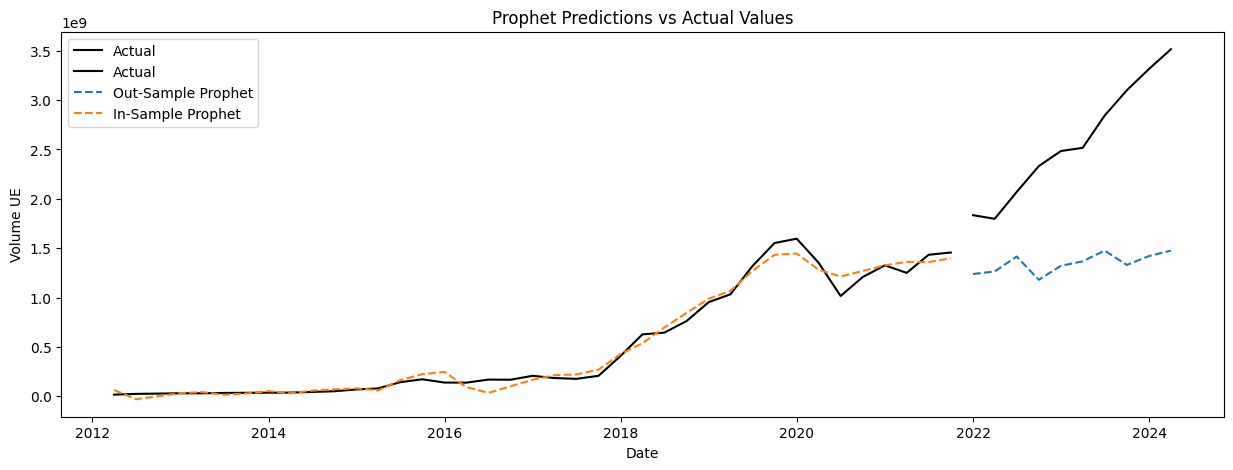

In [77]:
# Plot predictions
plt.figure(figsize=(15, 5))
plt.plot(data.iloc[train_size:].index, data['y_variable'].iloc[train_size:], label='Actual', color='black')
plt.plot(data.iloc[:train_size].index, data['y_variable'].iloc[:train_size], label='Actual', color='black')
plt.plot(data.iloc[train_size:].index, forecast['yhat'].iloc[train_size:], label=f'Out-Sample Prophet', linestyle='--')
plt.plot(data.iloc[:train_size].index, forecast['yhat'].iloc[:train_size], label=f'In-Sample Prophet', linestyle='--')
plt.legend()
plt.title('Prophet Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Volume UE')

plt.show()

#### AutoARIMA

14

In [66]:
autoArima = pm.auto_arima(train['y_variable'], start_p=1, start_q=1,
                         test='adf',
                         max_p=100, max_q=100, 
                         m=12, 
                         start_P=0, 
                         seasonal=True,
                         d=None, 
                         D=1, 
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True,
                         cv=TimeSeriesSplit(n_splits=5))

autoArima_ = pm.auto_arima(data['y_variable'], start_p=1, start_q=1,
                         test='adf',
                         max_p=100, max_q=100, 
                         m=12, 
                         start_P=0, 
                         seasonal=True,
                         d=None, 
                         D=1, 
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True,
                         cv=TimeSeriesSplit(n_splits=5))
# cv = model_selection.SlidingWindowForecastCV(window_size=10, step=3, h=3)
# cv_pred = model_selection.cross_val_predict(autoArima, train['vol_UE'], cv=cv, verbose=2, averaging="median")
fc, confint = autoArima.predict(n_periods=test.shape[0], return_conf_int=True)
# fc, confint = autoArima_.predict(n_periods=3, return_conf_int=True)
arima_train_pred = autoArima.predict_in_sample()
index_of_fc = np.arange(len(train['y_variable']), len(train['y_variable'])+test.shape[0])

# cv_series = pd.Series(cv_pred, index=test.index)
fc_series = pd.Series(fc)
# train_series = pd.Series(train_pred, index=train.index)
# lower_series = pd.Series(confint[:, 0], index=index_of_fc)
# upper_series = pd.Series(confint[:, 1], index=index_of_fc)

In [67]:
fc

2021-12-31   1386438671.759166
2022-03-31   1439364874.440052
2022-06-30   1502678386.174335
2022-09-30   1538833415.476326
2022-12-31   1614840463.002908
2023-03-31   1628354094.109407
2023-06-30   1656987616.021806
2023-09-30   1724140013.180698
2023-12-31   1963567481.869170
2024-03-31   2216729016.510941
Freq: QE-DEC, dtype: float64

In [ ]:
ts_forecast_df = forecast[-3:-2][['ds','yhat']]
ts_forecast_df['AutoARIMA'] = fc.reset_index(drop=True)[0]
ts_forecast_df = ts_forecast_df.rename(columns={'ds': 'Date', 'yhat':'Prophet'})
ts_forecast_df = ts_forecast_df.set_index('Date')
tsfc_df = ts_forecast_df.T
tsfc_df['Actual Value'] = '1,335,760,144'
display(tsfc_df)

Date       2024-05-01 00:00:00   Actual Value
Prophet       1,264,704,303.11  1,335,760,144
AutoARIMA     1,283,976,140.33  1,335,760,144

In [68]:
atrain_rmse, atrain_mape = calculate_metrics(train['y_variable'], arima_train_pred)
atest_rmse, atest_mape = calculate_metrics(test['y_variable'], fc_series)

# Append metrics to DataFrame
a_metrics = pd.DataFrame([{
    'Model': 'Auto ARIMA',
    'Train RMSE': atrain_rmse,
    'Test RMSE': atest_rmse,
    'Train MAPE': atrain_mape,
    'Test MAPE': atest_mape
}])

display(a_metrics)

Model      Train RMSE        Test RMSE  Train MAPE  Test MAPE
0  Auto ARIMA 95408794.310368 981324702.282047    0.155442   0.339770

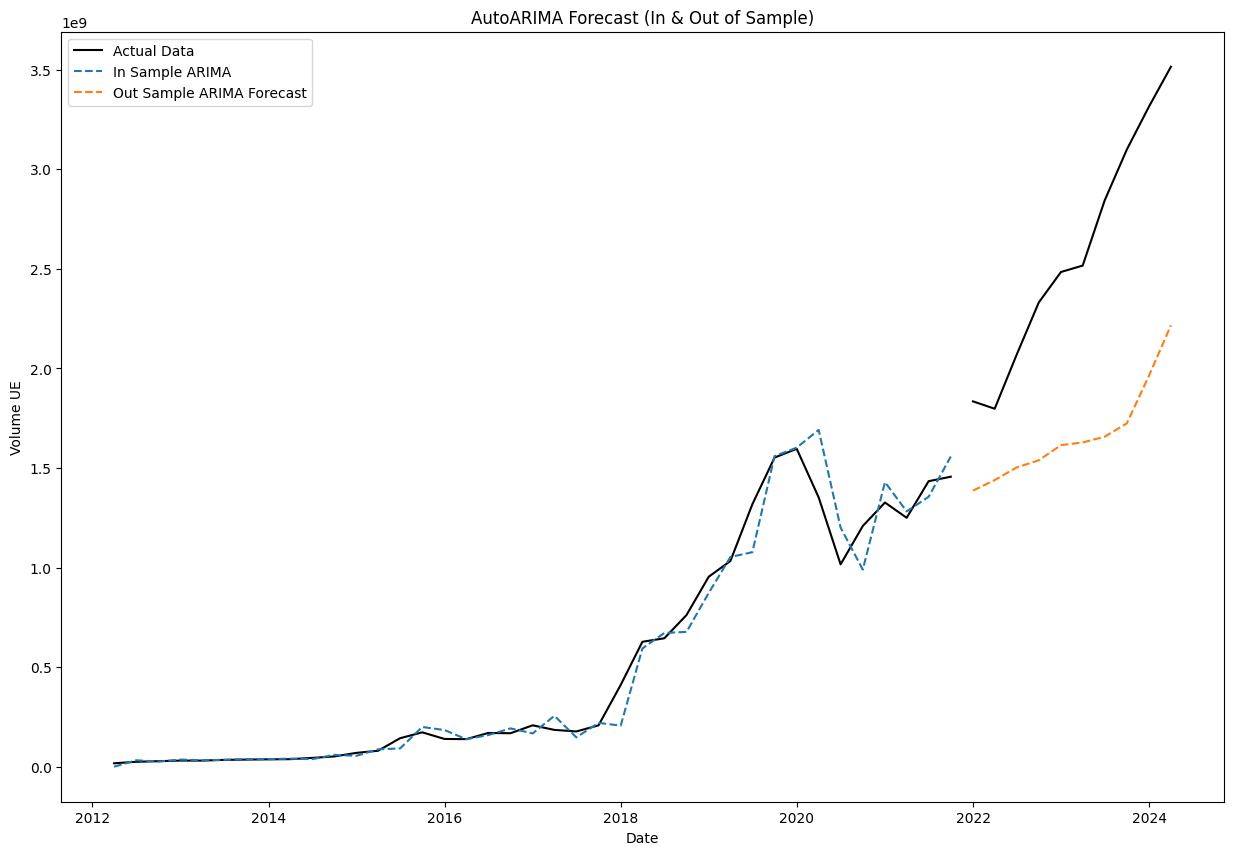

In [69]:
plt.figure(figsize=(15,10))
plt.plot(train.index, train['y_variable'], label='Actual Data', color='black')
plt.plot(train.index, arima_train_pred, label='In Sample ARIMA', linestyle='--')
plt.plot(test.index, test['y_variable'], color='black')
plt.plot(test.index, fc, label='Out Sample ARIMA Forecast', linestyle='--')
plt.legend()
plt.title("AutoARIMA Forecast (In & Out of Sample)")
plt.xlabel('Date')
plt.ylabel('Volume UE')
plt.show()

#### Seasonal Trend

In [69]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [62]:
# Decompose the time series using STL
stl = STL(data['y_variable'], seasonal=13, period=12)
result = stl.fit()

# Extract the seasonal, trend, and residual components
seasonal = result.seasonal
trend = result.trend
residual = result.resid

# Deseasonalize the data
deseasonalized = data['y_variable'] - seasonal

# Split deseasonalized data into train and test sets
train_size = int(len(deseasonalized) * 0.8)
train_deseasonalized, test_deseasonalized = deseasonalized[:train_size], deseasonalized[train_size:]

# Fit an Exponential Smoothing model on the deseasonalized data
model = ExponentialSmoothing(train_deseasonalized, trend='add', seasonal=None)
fitted_model = model.fit()

# Forecast the deseasonalized data
# deseasonalized_forecast = fitted_model.forecast(steps=len(test_deseasonalized))

# Reconstruct the forecasted values by adding the seasonal component back
# forecast_with_seasonality = deseasonalized_forecast + seasonal[-len(test_deseasonalized):].values

# Forecast future values beyond the test set
future_steps = len(test_deseasonalized) + 3 # Example: forecast 12 periods into the future
future_deseasonalized_forecast = fitted_model.forecast(steps=future_steps)
future_seasonal_component = np.tile(seasonal[:future_steps], future_steps // len(seasonal) + 1)[:future_steps]
future_forecast = future_deseasonalized_forecast + future_seasonal_component




C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [63]:
future_forecast

2021-12-31   1726482715.787086
2022-03-31   1864553471.684134
2022-06-30   1929595303.381870
2022-09-30   1918934718.576225
2022-12-31   1986188257.175580
2023-03-31   2026596940.485894
2023-06-30   2047775213.649392
2023-09-30   2086837716.642117
2023-12-31   2096944706.823144
2024-03-31   2051842682.524275
2024-06-30   2070817077.997370
2024-09-30   2167298245.383736
2024-12-31   2344316345.997530
Freq: QE-DEC, dtype: float64

In [64]:
stl_train_rmse, stl_train_mape = calculate_metrics(data['y_variable'].loc[train_deseasonalized.index], fitted_model.fittedvalues + seasonal[:len(fitted_model.fittedvalues)])
stl_test_rmse, stl_test_mape = calculate_metrics(data['y_variable'].loc[test_deseasonalized.index], future_forecast[:-3])

# Append metrics to DataFrame
stl_metrics = pd.DataFrame([{
    'Model': 'Seasonal Trend',
    'Train RMSE': stl_train_rmse,
    'Test RMSE': stl_test_rmse,
    'Train MAPE': stl_train_mape,
    'Test MAPE': stl_test_mape
}])

display(stl_metrics)

Model       Train RMSE        Test RMSE  Train MAPE  Test MAPE
0  Seasonal Trend 103748172.761157 772935057.988682    0.593389   0.212530

C:\Users\arnanda_p.i\AppData\Local\Temp\ipykernel_22784\2175826065.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=3, freq='M')


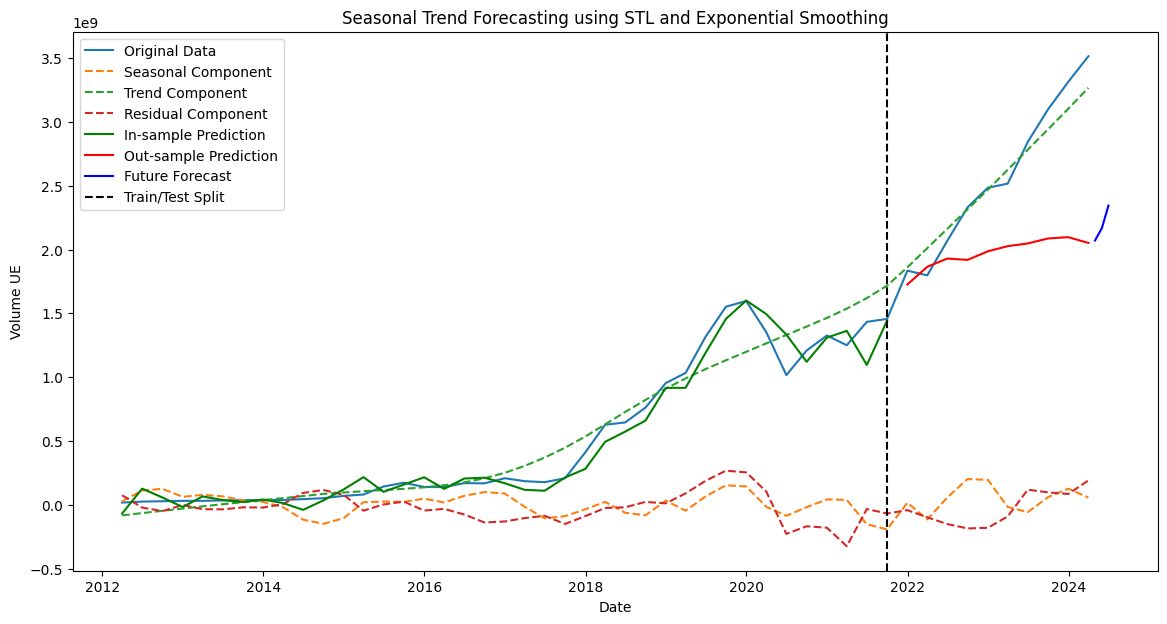

In [65]:
# Visualize the results
plt.figure(figsize=(14, 7))

# Plot original data
plt.plot(data['y_variable'], label='Original Data')
# Plot seasonal, trend, and residual components
plt.plot(seasonal, label='Seasonal Component', linestyle='--')
plt.plot(trend, label='Trend Component', linestyle='--')
plt.plot(residual, label='Residual Component', linestyle='--')
# Plot in-sample predictions
plt.plot(train_deseasonalized.index, fitted_model.fittedvalues + seasonal[:len(fitted_model.fittedvalues)], label='In-sample Prediction', color='green')
# Plot out-sample predictions
plt.plot(test_deseasonalized.index, future_forecast[:-3], label='Out-sample Prediction', color='red')
# Plot future predictions
future_index = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=3, freq='M')
plt.plot(future_index, future_forecast[-3:], label='Future Forecast', color='blue')
plt.axvline(x=train_deseasonalized.index[-1], color='black', linestyle='--', label='Train/Test Split')
plt.legend()
plt.title('Seasonal Trend Forecasting using STL and Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Volume UE')
plt.show()

#### gluonTS

In [88]:
from gluonts.mx import SimpleFeedForwardEstimator, Trainer, DeepAREstimator, MQCNNEstimator, TransformerEstimator
from gluonts.model.npts import NPTSPredictor
from gluonts.mx.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
from gluonts.evaluation import make_evaluation_predictions, backtest_metrics
from gluonts.evaluation import Evaluator
import json

In [89]:
def create_dataset_gluonts(data, train, test, period_data):
    train_ = ListDataset(
        [{"target": train['y_variable'].values, "start": train.index[0]}],
        freq=period_data,
    )

    test_ = ListDataset(
        [{"target": data['y_variable'].values, "start": data.index[0]}],
        freq=period_data,
    )

    eval_ = ListDataset(
        [{"target": test['y_variable'].values, "start": test.index[0]}],
        freq=period_data,
    )

    return test_, train_, eval_

def estimators(test_size, algorithm_name, epoch):
    if algorithm_name == 'Simple Feed Forward':
        SFF_estimator = SimpleFeedForwardEstimator(
            num_hidden_dimensions=[10],
            prediction_length=test_size,
            context_length=100,
            trainer=Trainer(ctx="cpu", epochs=epoch, learning_rate=1e-3, num_batches_per_epoch=100),
        )
        return SFF_estimator
    
    elif algorithm_name == 'DeepAR':
        DR_estimator = DeepAREstimator(
            freq='M',
            prediction_length=test_size,
            trainer=Trainer(ctx="cpu", epochs=epoch, learning_rate=1e-3, num_batches_per_epoch=100)
        )
        return DR_estimator
    
    elif algorithm_name == 'Transformer':
        T_estimator = TransformerEstimator(
            freq='M',
            prediction_length=test_size,
            trainer=Trainer(ctx="cpu", epochs=epoch, learning_rate=1e-3, num_batches_per_epoch=100)
        )
        return T_estimator
    
def gluonts_training(train_, the_estimator):
    the_predictor = the_estimator.train(train_)
    return the_predictor

def gluonts_forecast(the_predictor, train_, test_):
    is_forecast = list(the_predictor.predict(train_))
    os_forecast = list(the_predictor.predict(test_))
    return is_forecast, os_forecast

def gluonts_predict(train_, the_predictor):
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=train_,  # test dataset
        predictor=the_predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )
    return list(forecast_it), list(ts_it)

In [90]:
def deepar_metrics(train, test, test_forecast, train_predict, test_size):
    dr_test_pred = pd.Series(test_forecast[0].mean, index=test_forecast[0].index)
    dr_train_pred = pd.Series(train_predict[0].mean, index=train_predict[0].index)
    dtrain_rmse, dtrain_mape = calculate_metrics(train['y_variable'][-test_size:], dr_train_pred)
    dtest_rmse, dtest_mape = calculate_metrics(test['y_variable'], dr_test_pred)

    # Append metrics to DataFrame
    dr_metrics = pd.DataFrame([{
        'Model': 'DeepAR',
        'Train RMSE': dtrain_rmse,
        'Test RMSE': dtest_rmse,
        'Train MAPE': dtrain_mape,
        'Test MAPE': dtest_mape
    }])

    return dr_metrics

In [91]:
def plot_deepar(data, test_forecast, train_predict):
    plt.figure(figsize=(14,7))
    plt.plot(data.iloc[train_size:].index, data['y_variable'].iloc[train_size:], color='black')
    plt.plot(data.iloc[:train_size].index, data['y_variable'].iloc[:train_size], label='Actual', color='black')
    test_forecast[0].plot(show_label=True, intervals=(0.0, 0.9))
    train_predict[0].plot(show_label=True)
    plt.legend()
    plt.title("DeepAR Forecast (In & Out of Sample)")
    plt.xlabel('Date')
    plt.ylabel('Volume UE')
    plt.show()

C:\Users\arnanda_p.i\AppData\Local\Temp\ipykernel_22784\2408788853.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['Bulanan'] = pd.to_datetime(dff['Bulanan'])
C:\Users\arnanda_p.i\AppData\Local\Temp\ipykernel_22784\2408788853.py:4: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df_resampled = dff.resample('Q', on='Bulanan').sum()
C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\gluonts\dataset\common.py:255: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  ProcessDataEntry(to_offset(freq), one_dim_target, use_timestamp),
C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\gluonts\time_feature\lag.py:10

Model      Train RMSE         Test RMSE  Train MAPE  Test MAPE
0  DeepAR 18981715.371277 1897637064.254068    0.011886   0.546143

2021Q4   1890749184.000000
2022Q1   2623443968.000000
2022Q2   2744317440.000000
2022Q3   3261712384.000000
2022Q4   3796351744.000000
2023Q1   3698529792.000000
2023Q2   4165524224.000000
2023Q3   5807464960.000000
2023Q4   7201787904.000000
2024Q1   6101570560.000000
Freq: Q-DEC, dtype: float32

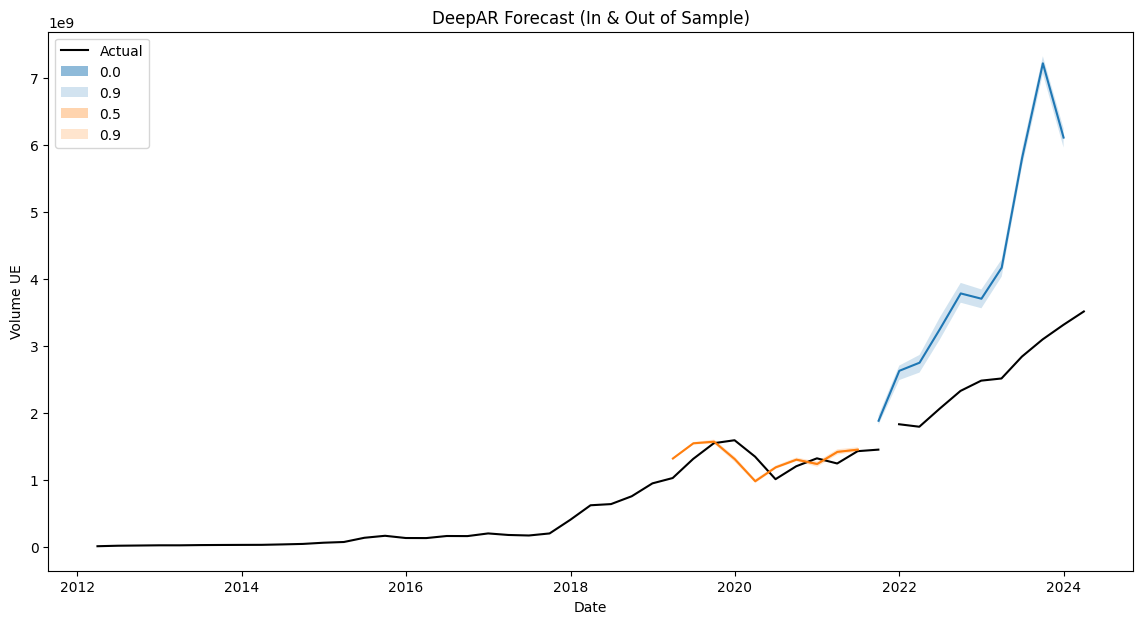

In [92]:
data2013 = data_ue_all[['Bulanan', 'vol_UE']].iloc[36:] #from 2013
data2018 = data_ue_all[['Bulanan', 'vol_UE']].iloc[96:] #from 2018

list_data = [data2013, data2018]

# Load data
period_data = 'Q'
start_period =  '2013'
if period_data == 'Q':
    data = data_ue_all[['Bulanan', 'vol_UE']]
    # Create a directory for saving models
    model_save_path = f"saved_models_ue-vol_2013_{period_data}"
    os.makedirs(model_save_path, exist_ok=True)
elif period_data == 'M':
    if start_period == '2013':
        data = data_ue_all[['Bulanan', 'vol_UE']].iloc[36:] #from 2013
        model_save_path = f"saved_models_ue-vol_{start_period}_{period_data}"
        os.makedirs(model_save_path, exist_ok=True)
    elif start_period == '2018':
        data = data_ue_all[['Bulanan', 'vol_UE']].iloc[96:] #from 2018
        model_save_path = f"saved_models_ue-vol_{start_period}_{period_data}"
        os.makedirs(model_save_path, exist_ok=True)

data = rename_y(data)
data = quartal_data(data)

data = feature_engineer(data, period=period_data)
train, test, train_size, test_size = train_test_split_(data)
X_train, y_train, X_test, y_test = features_and_target(data, train, test)

test_, train_, eval_  = create_dataset_gluonts(data, train, test, period_data=period_data)
DR_estimator = estimators(test_size, algorithm_name='DeepAR', epoch=100)
DR_predictor = gluonts_training(train_, the_estimator=DR_estimator)
test_forecast, out_forecast = gluonts_forecast(DR_predictor, train_, test_)
train_predict, ts_ = gluonts_predict(train_, DR_predictor)

dr_test_pred = pd.Series(test_forecast[0].mean, index=test_forecast[0].index)
dr_test_pred.to_csv(f"UE-Nominal_DeepAR-forecasting_periode-triwulanan.csv")
display(deepar_metrics(train, test, test_forecast, train_predict, test_size))
display(dr_test_pred)
plot_deepar(data, test_forecast, train_predict)


# for x, data in zip([2013, 2018], list_data):
#     print(f"data dari tahun {x}")
#     data = feature_engineer(data, period=period_data)
#     train, test, train_size, test_size = train_test_split_(data)
#     X_train, y_train, X_test, y_test = features_and_target(data, train, test)

#     test_, train_, eval_  = create_dataset_gluonts(data, train, test)
#     DR_estimator = estimators(test_size, algorithm_name='DeepAR', epoch=100)
#     DR_predictor = gluonts_training(train_, the_estimator=DR_estimator)
#     test_forecast, out_forecast = gluonts_forecast(DR_predictor, train_, test_)
#     train_predict, ts_ = gluonts_predict(train_, DR_predictor)

#     dr_test_pred = pd.Series(test_forecast[0].mean, index=test_forecast[0].index)
#     dr_test_pred.to_csv(f"UE-Nominal_DeepAR-forecasting_periode-{x}.csv")
#     display(deepar_metrics(train, test, test_forecast, train_predict, test_size))
#     display(dr_test_pred)
#     plot_deepar(data, test_forecast, train_predict)

#### try TS Models

In [134]:
# Define models
models = {
    'AutoARIMA': {
        'model': None  # Placeholder for the fitted model
    },
    'Prophet': {
        'model': None  # Placeholder for the fitted model
    },
    'DeepAR': {
        'model': None  # Placeholder for the fitted model
    },
    # 'Simple Feed Forward': {
    #     'model': None  # Placeholder for the fitted model
    # },
    # 'Transformer': {
    #     'model': None  # Placeholder for the fitted model
    # },
    'Seasonal Trend': {
        'model': None  # Placeholder for the fitted model
    },
    'NPTS': {
        'model': None  # Placeholder for the fitted model
    }
}

# Train models
for name, model_info in models.items():
    if name == 'AutoARIMA':
        # Fit AutoARIMA
        model_info['model'] = auto_arima(train['vol_UE'], seasonal=True, m=12)
    elif name == 'Prophet':
        # Fit Prophet
        model = Prophet()
        model.fit(train.reset_index().rename(columns={'Bulanan': 'ds', 'vol_UE': 'y'}))
        model_info['model'] = model
    # elif name in ['DeepAR', 'Simple Feed Forward', 'Transformer']:
        # Fit GluonTS models
        # if name == 'DeepAR':
        #     estimator = DeepAREstimator(
        #         prediction_length=12,
        #         freq='M',
        #         trainer=Trainer(epochs=10)
        #     )
        # elif name == 'Simple Feed Forward':
        #     estimator = SimpleFeedForwardEstimator(
        #         prediction_length=12,
        #         freq='M',
        #         trainer=Trainer(epochs=10)
        #     )
        # elif name == 'Transformer':
        #     estimator = TransformerEstimator(
        #         prediction_length=12,
        #         freq='M',
        #         trainer=Trainer(epochs=10)
        #     )
        # predictor = estimator.train(train)
        # model_info['model'] = predictor
    # elif name == 'Seasonal Trend':
    #     # Fit Seasonal Trend
    #     model = STL(train, seasonal=12).fit()
    #     model_info['model'] = model
    # elif name == 'NPTS':
    #     # Fit NPTS (Naive Periodic Time Series)
    #     model = ExponentialSmoothing(train['vol_UE'], seasonal=12).fit()
    #     model_info['model'] = model

# Generate forecasts
forecasts = {}
for name, model_info in models.items():
    if name in ['AutoARIMA', 'Prophet', 'Seasonal Trend', 'NPTS']:
        forecasts[name] = model_info['model'].predict(start=test.index[0], end=test.index[-1])
    else:
        forecast_it, ts_it = model_info['model'].make_evaluation_predictions(
            dataset=test, num_samples=len(test)
        )
        forecasts[name] = list(forecast_it)

# Evaluate models
results = {}
for name, forecast in forecasts.items():
    if name in ['AutoARIMA', 'Prophet', 'Seasonal Trend', 'NPTS']:
        y_pred = forecast
    else:
        y_pred = np.concatenate([sample.mean for sample in forecast])
    rmse = np.sqrt(mean_squared_error(test['value'], y_pred))
    mape = mean_absolute_percentage_error(test['value'], y_pred)
    results[name] = {'RMSE': rmse, 'MAPE': mape}

# Print evaluation results
for name, metrics in results.items():
    print(f"{name}: RMSE = {metrics['RMSE']:.2f}, MAPE = {metrics['MAPE']:.2f}")

# Plot forecasts
plt.figure(figsize=(12, 8))
plt.plot(train.index, train['value'], label='Train')
plt.plot(test.index, test['value'], label='Test', color='black')

for name, forecast in forecasts.items():
    if name in ['AutoARIMA', 'Prophet', 'Seasonal Trend', 'NPTS']:
        plt.plot(test.index, forecast, label=name)
    else:
        y_pred = np.concatenate([sample.mean for sample in forecast])
        plt.plot(test.index, y_pred, label=name)

plt.title('Time Series Forecasts')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

23:22:17 - cmdstanpy - INFO - Chain [1] start processing
23:22:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\arnanda_p.i\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


TypeError: predict() got an unexpected keyword argument 'start'